In [2]:
import numpy as np
import sys
sys.path.append("../../src/")
import utility
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

from scipy.stats import kruskal
from statsmodels.stats.proportion import proportions_chisquare

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import statsmodels.api as sm

from scipy import stats

import pandas as pd

import math
from lifelines import CoxPHFitter


In [3]:
df_IEA_train = pd.read_csv("../../output/IEA_train.csv").set_index("sid")
df_IEA_test = pd.read_csv("../../output/IEA_test.csv").set_index("sid")

df_IEA_all = pd.concat( [df_IEA_train, df_IEA_test] )

In [4]:
df = utility.load_data()

df_used = pd.merge(df, df_IEA_all, left_index = True, right_index = True)

/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

# Regression with Both IEAs and COPD measurements

In [5]:
independents = ["IEA0", "IEA1", 
       "Age_P2", "gender", 'race', 'ATS_PackYears_P2', 'BMI_P2', "smoking_status_P2",
       'pctEmph_Thirona_P2', 'Perc15_Insp_Thirona_P2', 'pctGasTrap_Thirona_P2',
       'Pi10_Thirona_P2',  'WallAreaPct_seg_Thirona_P2']

models_IEA = []


In [6]:
p_values = []

cov_dict_IEA = {iii:[] for iii in independents}
exp_cov_dict_IEA = {iii:[] for iii in independents}
            
    
for ccc in ["Frequent_Exacerbator_P2", "Frequent_Exacerbator_P3"]:
    X = df_used[independents
               ]
        
    y = df_used[ccc]
    idx = np.bitwise_and(~np.isnan(y), ~np.isnan(X).any(1))
    
    X = X[idx]
    y = y[idx]
    
    X = sm.add_constant(X.apply(stats.zscore))
    
    
    M_logit = sm.Logit(y, X).fit()

    models_IEA.append(M_logit)

    
    
    v = M_logit.summary2().tables[1].values
    
    
    for iii in range(1, len(independents) + 1):
        col = independents[iii-1]
        eee = "{:.2f}".format(v[iii, 0])
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI1 = "\n({:.2f}, {:.2f})".format(v[iii, 4], v[iii, 5])
        
        cov_dict_IEA[col].append(eee + CI1)

        
        col = independents[iii-1]
        eee = "{:.2f}".format( np.exp( v[iii, 0]) )
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI2 = "\n({:.2f}, {:.2f})".format( np.exp(v[iii, 4]), np.exp(v[iii, 5]))
        
        exp_cov_dict_IEA[col].append(eee + CI2)
        
    

Optimization terminated successfully.
         Current function value: 0.201760
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.153373
         Iterations 8


In [7]:
df_survival = df_used[ ["days_P2", "vital_status"] + independents ]

df_survival = df_survival[~df_survival.isnull().any(1)]
df_survival[ independents ] = df_survival[ independents ].apply(stats.zscore)

M = CoxPHFitter(penalizer = 0., l1_ratio=0.5)
M.fit(df_survival, duration_col = "days_P2", event_col = "vital_status")


models_IEA.append(M)

v = M.summary

for col in v.index:
    eee = "{:.2f}".format( v.loc[col, "coef"] )
    ppp =  v.loc[col, "p"]
    if ppp<.05:
        eee += "*"
    if ppp<.01:
        eee += "*"
    if ppp<.001:
        eee += "*"

    CI1 = "\n({:.2f}, {:.2f})".format(v.loc[col, "coef lower 95%"], v.loc[col, "coef upper 95%"])

    cov_dict_IEA[col].append(eee + CI1)

    eee = "{:.2f}".format( np.exp( v.loc[col, "coef"] ) )
    ppp =  v.loc[col, "p"]
    if ppp<.05:
        eee += "*"
    if ppp<.01:
        eee += "*"
    if ppp<.001:
        eee += "*"

    CI2 = "\n({:.2f}, {:.2f})".format( np.exp( v.loc[col, "coef lower 95%"]), np.exp(v.loc[col, "coef upper 95%"]))

    exp_cov_dict_IEA[col].append(eee + CI2)
    

# Base Regression with COPD measurements only

In [8]:
independents = ["Age_P2", "gender", 'race', 'ATS_PackYears_P2', 'BMI_P2', "smoking_status_P2",
       'pctEmph_Thirona_P2', 'Perc15_Insp_Thirona_P2', 'pctGasTrap_Thirona_P2',
       'Pi10_Thirona_P2',  'WallAreaPct_seg_Thirona_P2']


models_base = []
cov_dict_base = {iii:[] for iii in independents}

In [9]:
p_values = []

cov_dict_base = {iii:[] for iii in independents}
exp_cov_dict_base = {iii:[] for iii in independents}
            
    
for ccc in ["Frequent_Exacerbator_P2", "Frequent_Exacerbator_P3"]:
    X = df_used[independents
               ]
        
    y = df_used[ccc]
    idx = np.bitwise_and(~np.isnan(y), ~np.isnan(X).any(1))
    
    X = X[idx]
    y = y[idx]
    
    X = sm.add_constant(X.apply(stats.zscore))
    
    
    M_logit = sm.Logit(y, X).fit()

    models_base.append(M_logit)

    
    
    v = M_logit.summary2().tables[1].values
    
    
    for iii in range(1, len(independents) + 1):
        col = independents[iii-1]
        eee = "{:.2f}".format(v[iii, 0])
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI1 = "\n({:.2f}, {:.2f})".format(v[iii, 4], v[iii, 5])
        
        cov_dict_base[col].append(eee + CI1)

        
        col = independents[iii-1]
        eee = "{:.2f}".format( np.exp( v[iii, 0]) )
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI2 = "\n({:.2f}, {:.2f})".format( np.exp(v[iii, 4]), np.exp(v[iii, 5]))
        
        exp_cov_dict_base[col].append(eee + CI2)
        
    

Optimization terminated successfully.
         Current function value: 0.202806
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.153463
         Iterations 8


In [10]:
df_survival = df_used[ ["days_P2", "vital_status"] + independents ]

df_survival = df_survival[~df_survival.isnull().any(1)]
df_survival[ independents ] = df_survival[ independents ].apply(stats.zscore)

M = CoxPHFitter(penalizer = 0., l1_ratio=0.5)
M.fit(df_survival, duration_col = "days_P2", event_col = "vital_status")


models_base.append(M)

v = M.summary

for col in v.index:
    eee = "{:.2f}".format( v.loc[col, "coef"] )
    ppp =  v.loc[col, "p"]
    if ppp<.05:
        eee += "*"
    if ppp<.01:
        eee += "*"
    if ppp<.001:
        eee += "*"

    CI1 = "\n({:.2f}, {:.2f})".format(v.loc[col, "coef lower 95%"], v.loc[col, "coef upper 95%"])

    cov_dict_base[col].append(eee + CI1)

    eee = "{:.2f}".format( np.exp( v.loc[col, "coef"] ) )
    ppp =  v.loc[col, "p"]
    if ppp<.05:
        eee += "*"
    if ppp<.01:
        eee += "*"
    if ppp<.001:
        eee += "*"

    CI2 = "\n({:.2f}, {:.2f})".format( np.exp( v.loc[col, "coef lower 95%"]), np.exp(v.loc[col, "coef upper 95%"]))

    exp_cov_dict_base[col].append(eee + CI2)
    

# Computing p-values for likelihood ratio test

In [11]:
from scipy.stats.distributions import chi2


p_values = []

for iii in range(3):
    mmm = models_IEA[iii]
    lll = models_base[iii]
    
    if iii == 2:
        ll0 = lll.log_likelihood_
        ll1 = mmm.log_likelihood_
        
        dg0 = 11
        dg1 = 13
    else:       
        ll0 = lll.llf
        ll1 = mmm.llf
        dg0 = lll.df_model
        dg1 = mmm.df_model
    
    chi2_stat = -2 * (ll0-ll1)
    p = chi2.sf(chi2_stat, dg1-dg0)
    
    p_values.append( p )

p_values_str = []
for iii in p_values:
    if iii < .001:
        p_values_str.append("<.001")
    else:
        p_values_str.append("{:.3f}".format(iii))
        
p_values_str = np.array(p_values_str)[:, None]

# Table for p-values

In [12]:
rows = ["Frequent Exacerbator (History)", "Frequent Exacerbator (Future)", "Mortality"
       ]

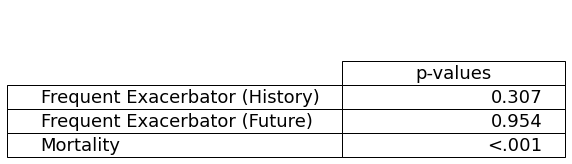

In [13]:
fig, ax = plt.subplots(figsize=(2,1))

the_table=plt.table(cellText = p_values_str, rowLabels = rows, 
                    colLabels = ["p-values"])

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

# Table for beta coeffcients ( COPD measurements )

In [14]:
independents = [
       "Age_P2", "gender", 'race', 'ATS_PackYears_P2', 'BMI_P2', "smoking_status_P2",
       'pctEmph_Thirona_P2', 'Perc15_Insp_Thirona_P2', 'pctGasTrap_Thirona_P2',
       'Pi10_Thirona_P2',  'WallAreaPct_seg_Thirona_P2']

cov_label = [ 'Age',
 'Gender,\n%females', 'Race, \n%African-American',
 'Pack Years', 'Body Mass Index \n(BMI)',
 'Smoking Status', '%Emphysema \nat -950HU',
 'perc15',
 '%Gas Trapping',
 'Pi10',
 '%Airway Wall, \nSegmental']

In [15]:
table = np.array( [ [cov_dict_base[ccc][iii] for ccc in independents] for iii in range(len(models_base))  ] )

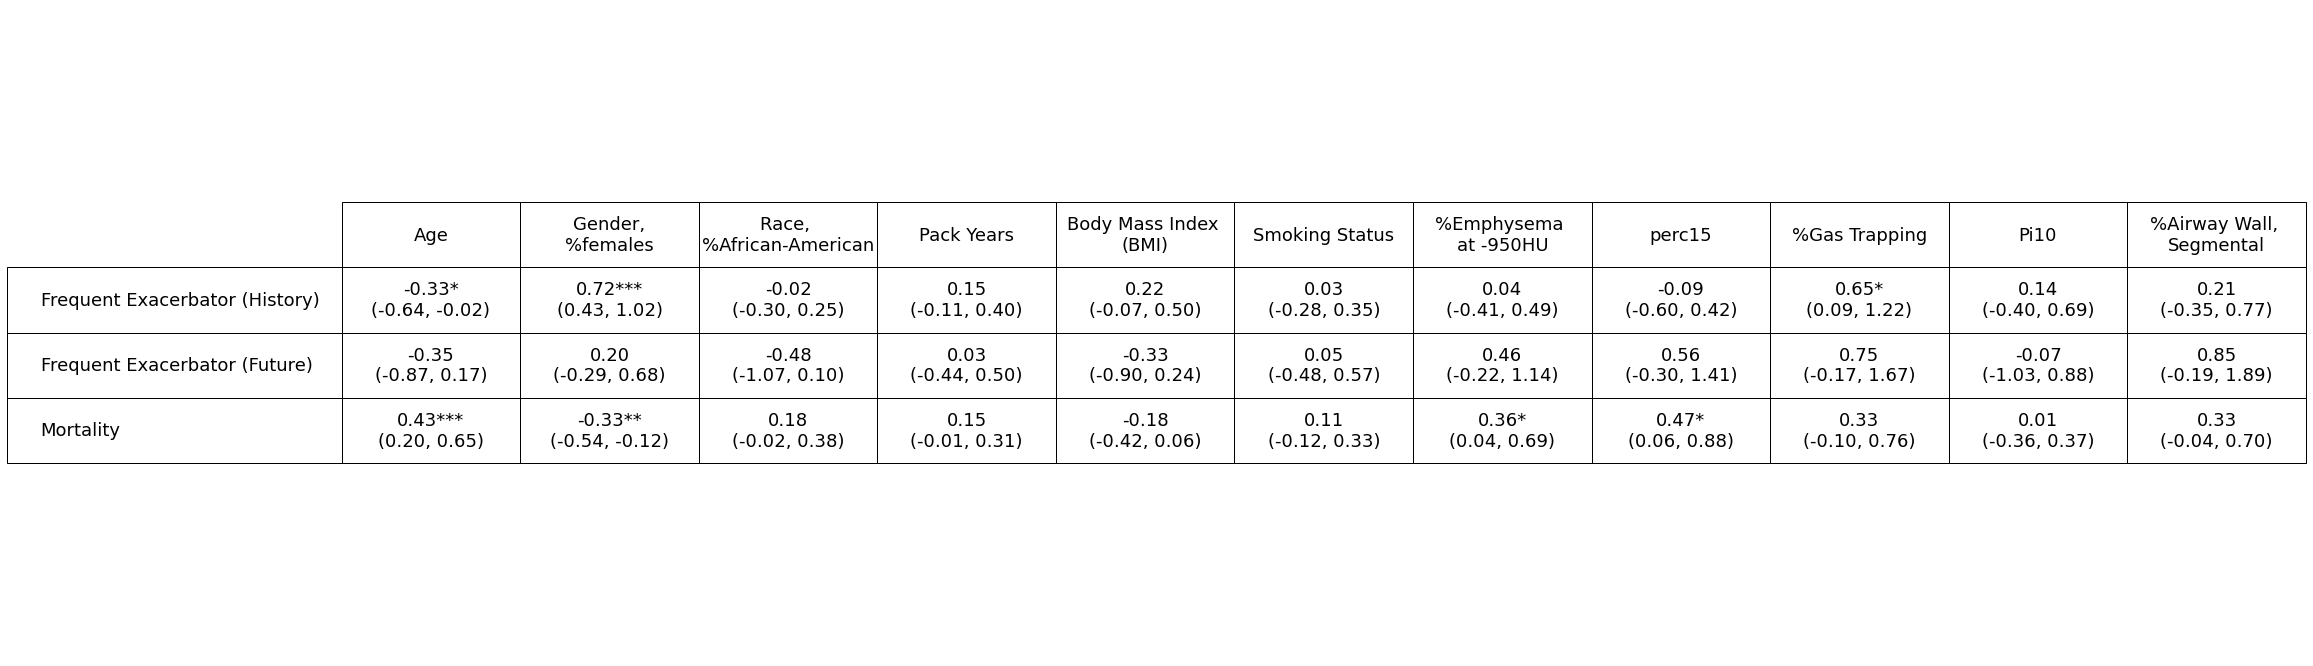

In [16]:
fig, ax = plt.subplots(figsize=(16,12))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    

# Table for Odds / Hazard Ratio ( COPD measurements )

In [17]:
table = np.array( [ [exp_cov_dict_base[ccc][iii] for ccc in independents] for iii in range(len(models_base))  ] )

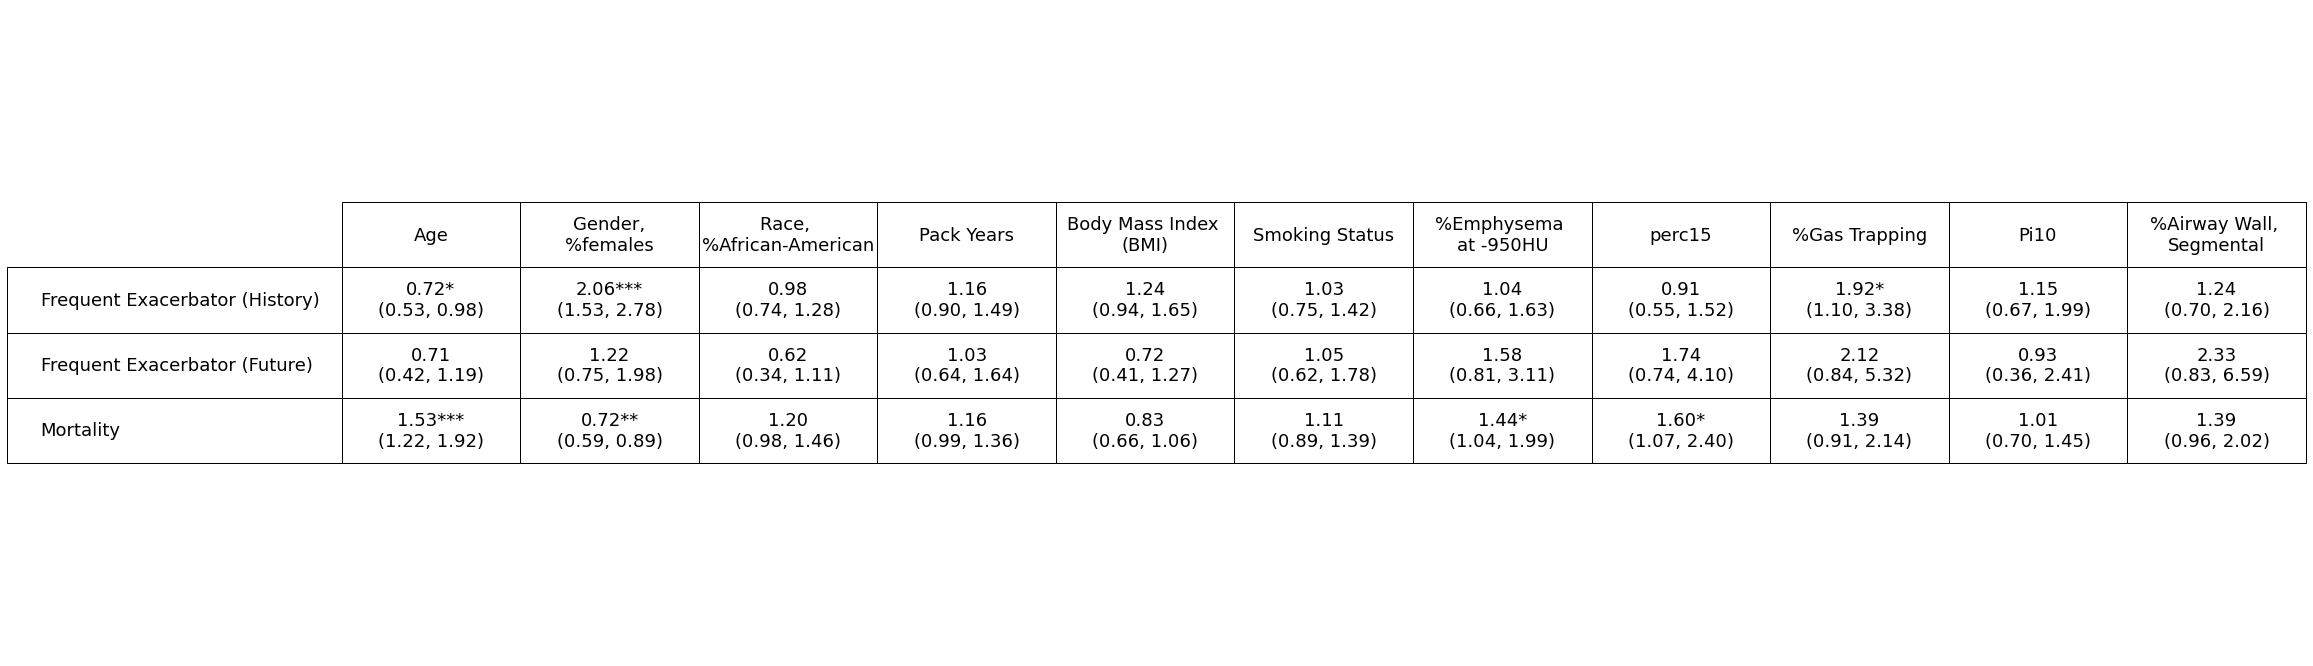

In [18]:
fig, ax = plt.subplots(figsize=(16,12))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    

# Table for beta coeffcients ( COPD measurements + IEAs )

In [19]:
independents = ["IEA0", "IEA1", 
       "Age_P2", "gender", 'race', 'ATS_PackYears_P2', 'BMI_P2', "smoking_status_P2",
       'pctEmph_Thirona_P2', 'Perc15_Insp_Thirona_P2', 'pctGasTrap_Thirona_P2',
       'Pi10_Thirona_P2',  'WallAreaPct_seg_Thirona_P2']

cov_label = [ 'IEA$_{emph}$', 'IEA$_{eairway}$' ,'Age',
 'Gender,\n%females', 'Race, \n%African-American',
 'Pack Years', 'Body Mass Index \n(BMI)',
 'Smoking Status', '%Emphysema \nat -950HU',
 'perc15',
 '%Gas Trapping',
 'Pi10',
 '%Airway Wall, \nSegmental']

In [20]:
table = np.array( [ [cov_dict_IEA[ccc][iii] for ccc in independents] for iii in range(len(models_base))  ] )

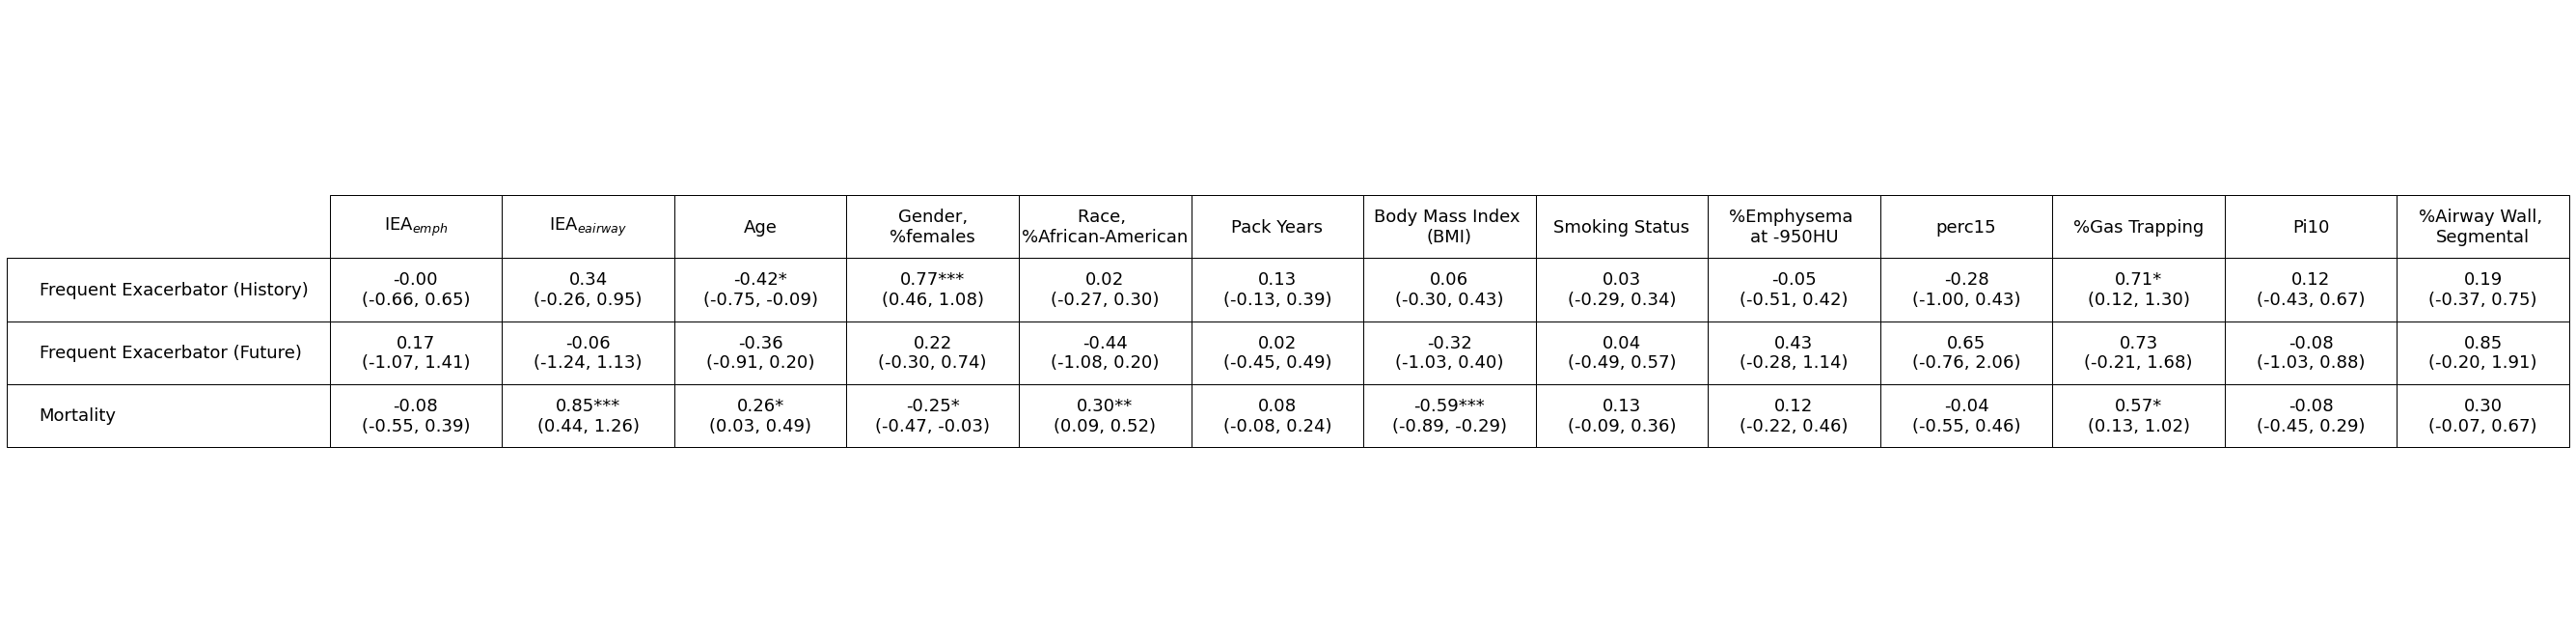

In [21]:
fig, ax = plt.subplots(figsize=(16,12))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    

# Table for Odds / Hazard Ratio ( COPD measurements + IEAs)

In [22]:
table = np.array( [ [exp_cov_dict_IEA[ccc][iii] for ccc in independents] for iii in range(len(models_base))  ] )

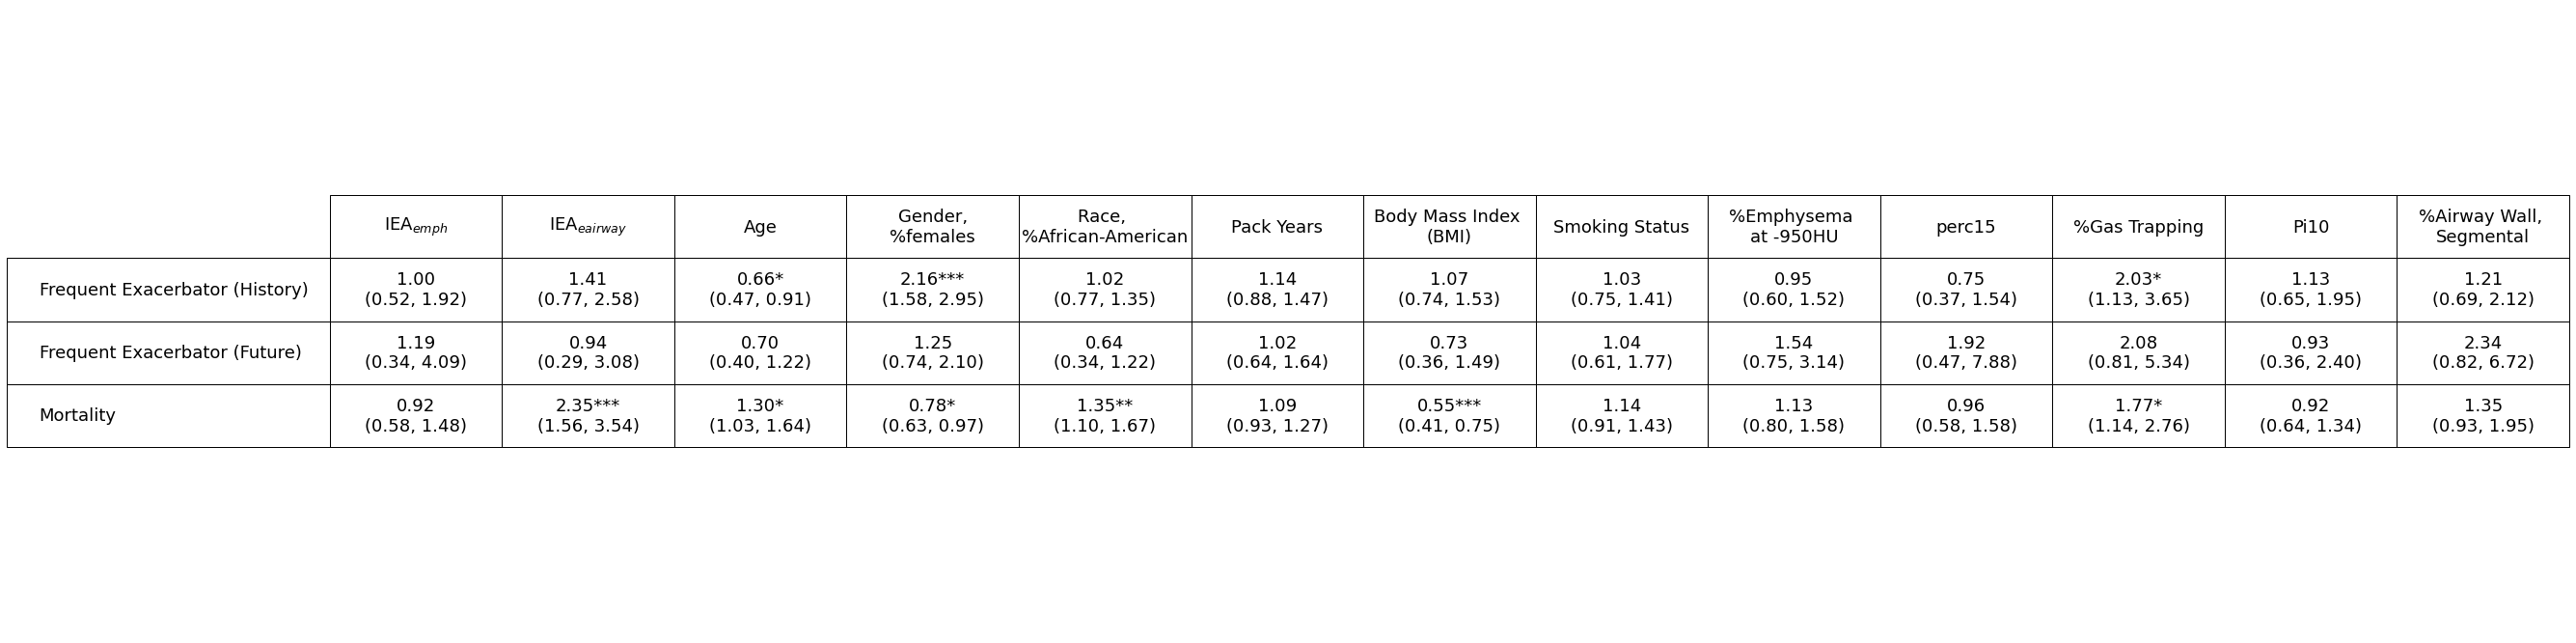

In [23]:
fig, ax = plt.subplots(figsize=(16,12))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    